In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import timm
from PIL import Image
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import warnings
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import datetime

warnings.filterwarnings('ignore', category=FutureWarning, module='torch.serialization')

class CustomDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None, label_mapping=None, domain='lab'):
        self.img_dir = img_dir
        self.transform = transform
        self.domain = domain
        self.data = pd.read_csv(csv_path, header=None)
        self.image_names = self.data.iloc[:, 0]
        self.crop_labels = self.data.iloc[:, 1]
        self.disease_labels = self.data.iloc[:, 2]
        
        valid_data = []
        for idx, row in self.data.iterrows():
            img_path = os.path.join(img_dir, row[0])
            if os.path.exists(img_path):
                valid_data.append(row)
            else:
                print(f"Warning: Image not found: {img_path}")
        self.data = pd.DataFrame(valid_data)

        if label_mapping is None:
            self.crop_to_idx = {label: idx for idx, label in enumerate(sorted(self.crop_labels.unique()))}
            self.disease_to_idx = {label: idx for idx, label in enumerate(sorted(self.disease_labels.unique()))}
        else:
            self.crop_to_idx = label_mapping['crop']
            self.disease_to_idx = label_mapping['disease']

        print(f"Found {len(set(self.crop_labels))} unique crop labels, "
              f"{len(set(self.disease_labels))} unique disease labels")
        print(f"Valid images found: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            img_name = self.data.iloc[idx, 0]
            crop_label = self.data.iloc[idx, 1]
            disease_label = self.data.iloc[idx, 2]
            
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            
            crop_idx = self.crop_to_idx[crop_label]
            disease_idx = self.disease_to_idx[disease_label]

            return {
                'image': image,
                'crop_label': torch.tensor(crop_idx, dtype=torch.long),
                'disease_label': torch.tensor(disease_idx, dtype=torch.long),
                'domain_label': torch.tensor(1 if self.domain == 'field' else 0, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading item {idx}: {str(e)}")
            return None

class DualBranchEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=pretrained, features_only=True, out_indices=[2, 4])
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            features = self.backbone(dummy)
            mid_channels = features[0].shape[1]
            final_channels = features[1].shape[1]
        
        self.local_branch = nn.Sequential(
            nn.Conv2d(mid_channels, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        
        self.global_branch = nn.Sequential(
            nn.Conv2d(final_channels, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        
        self.local_attention = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.global_attention = nn.Sequential(
            nn.Conv2d(final_channels, final_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(final_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        mid_features, final_features = features[0], features[1]
        
        local_attention = self.local_attention(mid_features)
        global_attention = self.global_attention(final_features)
        
        local_feat = mid_features * local_attention
        global_feat = final_features * global_attention
        
        local_features = self.local_branch(local_feat)
        global_features = self.global_branch(global_feat)
        
        attention_maps = {
            'local_attention': local_attention,
            'global_attention': global_attention
        }
        return local_features, global_features, attention_maps

class ProjectionMLP(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int = 512, out_dim: int = 128, num_layers: int = 2):
        super().__init__()
        layers = []
        
        layers.extend([
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True)
        ])
        
        for _ in range(num_layers - 2):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(inplace=True)
            ])
            
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class CompositionalFeatureLearning(nn.Module):
    def __init__(self, local_dim=256, global_dim=512, hidden_dim=512, out_dim=128):
        super().__init__()
        self.crop_projector = ProjectionMLP(
            in_dim=global_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )
        self.disease_projector = ProjectionMLP(
            in_dim=local_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )
        self.disease_agnostic_projector = ProjectionMLP(
            in_dim=global_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )
        self.crop_agnostic_projector = ProjectionMLP(
            in_dim=local_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )

    def forward(self, local_features, global_features):
        crop_emb = self.crop_projector(global_features)
        disease_emb = self.disease_projector(local_features)
        disease_agnostic = self.disease_agnostic_projector(global_features)
        crop_agnostic = self.crop_agnostic_projector(local_features)
        
        return {
            'crop_embedding': F.normalize(crop_emb, p=2, dim=1),
            'disease_embedding': F.normalize(disease_emb, p=2, dim=1),
            'disease_agnostic': F.normalize(disease_agnostic, p=2, dim=1),
            'crop_agnostic': F.normalize(crop_agnostic, p=2, dim=1)
        }

class CompZSLNet(nn.Module):
    def __init__(self, num_crops: int, num_diseases: int, num_compositions: int, pretrained: bool = True, feature_dim: int = 256):
        super().__init__()
        self.encoder = DualBranchEncoder(pretrained=pretrained)
        
        self.comp_learning = CompositionalFeatureLearning(
            local_dim=256,
            global_dim=512,
            hidden_dim=512,
            out_dim=feature_dim
        )
        
        self.crop_classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_crops)
        )
        
        self.disease_classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_diseases)
        )

    def forward(self, images):
        local_features, global_features, attention_maps = self.encoder(images)
        embeddings = self.comp_learning(local_features, global_features)
        
        crop_preds = self.crop_classifier(embeddings['crop_embedding'])
        disease_preds = self.disease_classifier(embeddings['disease_embedding'])

        return {
            'crop_preds': crop_preds,
            'disease_preds': disease_preds,
            'embeddings': embeddings
        }

def get_label_mapping(csv_path):
    df = pd.read_csv(csv_path, header=None)
    crop_labels = sorted(df.iloc[:, 1].unique())
    disease_labels = sorted(df.iloc[:, 2].unique())
    
    return {
        'crop': {label: idx for idx, label in enumerate(crop_labels)},
        'disease': {label: idx for idx, label in enumerate(disease_labels)}
    }

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = {'crop': [], 'disease': []}
    all_labels = {'crop': [], 'disease': []}
    total_correct = {'crop': 0, 'disease': 0}
    total_correct_top1 = {'crop': 0, 'disease': 0}
    top5_correct = {'crop': 0, 'disease': 0}
    total_samples = 0

    per_class_correct = {'crop': {}, 'disease': {}}
    per_class_total = {'crop': {}, 'disease': {}}

    with torch.no_grad():
        # Add tqdm progress bar
        progress_bar = tqdm(dataloader, desc='Evaluating', unit='batch')
        
        for batch_idx, batch in enumerate(progress_bar):
            try:
                images = batch['image'].to(device)
                labels = {
                    'crop': batch['crop_label'].to(device),
                    'disease': batch['disease_label'].to(device)
                }

                outputs = model(images)

                for task in ['crop', 'disease']:
                    preds = outputs[f'{task}_preds']
                    top1_preds = preds.argmax(dim=1)
                    top5_preds = torch.topk(preds, 5, dim=1).indices

                    total_correct[task] += (top1_preds == labels[task]).sum().item()
                    total_correct_top1[task] += (top1_preds == labels[task]).sum().item()
                    top5_correct[task] += sum([labels[task][i] in top5_preds[i] for i in range(len(labels[task]))])

                    all_preds[task].extend(top1_preds.cpu().numpy())
                    all_labels[task].extend(labels[task].cpu().numpy())

                    for label in labels[task].cpu().numpy():
                        if label not in per_class_correct[task]:
                            per_class_correct[task][label] = 0
                            per_class_total[task][label] = 0
                        per_class_total[task][label] += 1

                    for label, pred in zip(labels[task].cpu().numpy(), top1_preds.cpu().numpy()):
                        if label == pred:
                            per_class_correct[task][label] += 1

                total_samples += labels['crop'].size(0)

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {str(e)}")
                continue

    if total_samples == 0:
        raise ValueError("No samples were successfully processed")

    # Calculate metrics (rest of the function remains the same)
    accuracies = {task: (total_correct[task] / total_samples) * 100 for task in ['crop', 'disease']}
    top1_accuracy = {task: (total_correct_top1[task] / total_samples) * 100 for task in ['crop', 'disease']}
    top5_accuracies = {task: (top5_correct[task] / total_samples) * 100 for task in ['crop', 'disease']}
    avg_accuracy = {}
    avg_accuracy_per_class = {}
    precisions = {}

    for task in ['crop', 'disease']:
        per_class_accuracies = [
            per_class_correct[task][cls] / per_class_total[task][cls]
            for cls in per_class_correct[task]
        ]
        avg_accuracy_per_class[task] = (sum(per_class_accuracies) / len(per_class_accuracies)) * 100

        per_class_precisions = [
            per_class_correct[task][cls] / max(np.bincount(all_preds[task])[cls], 1)
            for cls in per_class_correct[task]
        ]
        precisions[task] = (sum(per_class_precisions) / len(per_class_precisions)) * 100

    return {
        'top1_accuracy': top1_accuracy,        # We keep this as our main accuracy metric
        'top5_accuracies': top5_accuracies,    # For top-5 performance
        'avg_accuracy': avg_accuracy_per_class, # For per-class average
        'predictions': all_preds,              # Needed for confusion matrices
        'labels': all_labels                   # Needed for confusion matrices
    }

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    n_classes = len(class_names)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nPrediction Distribution:")
    total_samples = np.sum(cm)
    for i in range(n_classes):
        predictions_for_class = np.sum(cm[:, i])
        if predictions_for_class > 0:
            percentage = (predictions_for_class / total_samples) * 100
            print(f"Class {i}: {predictions_for_class} predictions ({percentage:.2f}%)")

#Save results in cvs file
def save_results_to_csv(results, model_name, output_file='evaluation_results.csv'):
    """
    Save evaluation results to a CSV file, excluding confusion matrices. If the model 
    already exists in the file, its previous results will be overwritten with the new ones.
    
    Args:
        results (dict): Dictionary containing evaluation results for each test set
        model_name (str): Name of the model being evaluated
        output_file (str): Name of the output CSV file
    """
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    data_rows = []
    
    for test_set_name, test_results in results.items():
        base_row = {
            'Timestamp': timestamp,
            'Model Name': model_name,
            'Test Set': test_set_name,
        }
        
        for task in ['crop', 'disease']:
            metrics = {
                f'{task.title()} Top-1 Accuracy': test_results['top1_accuracy'][task],
                f'{task.title()} Top-5 Accuracy': test_results['top5_accuracies'][task],
                f'{task.title()} Average Accuracy': test_results['avg_accuracy'][task],
            }
            base_row.update(metrics)
        
        data_rows.append(base_row)
    
    # Calculate harmonic means if all test sets are present
    if all(k in results for k in ['PV test seen', 'PV test unseen', 'PD test unseen']):
        harmonic_means_row = {
            'Timestamp': timestamp,
            'Model Name': model_name,
            'Test Set': 'Harmonic Means'
        }
        
        for task in ['crop', 'disease']:
            seen_acc = results['PV test seen']['top1_accuracy'][task]
            unseen_acc_pv = results['PV test unseen']['top1_accuracy'][task]
            unseen_acc_pd = results['PD test unseen']['top1_accuracy'][task]
            
            # Calculate all three harmonic means
            h_mean_pv = (2 * seen_acc * unseen_acc_pv) / (seen_acc + unseen_acc_pv)
            h_mean_pd = (2 * seen_acc * unseen_acc_pd) / (seen_acc + unseen_acc_pd)
            h_mean_pv_pd = (2 * seen_acc * ((unseen_acc_pv + unseen_acc_pd)/2)) / (
                    seen_acc + ((unseen_acc_pv + unseen_acc_pd)/2))
            
            # Add all harmonic means to the results
            harmonic_means_row.update({
                f'{task.title()} H-Mean (PV Seen vs PV Unseen)': h_mean_pv,
                f'{task.title()} H-Mean (PV Seen vs PD Unseen)': h_mean_pd,
                f'{task.title()} H-Mean (PV Seen vs PV+PD Unseen Average)': h_mean_pv_pd
            })
        
        data_rows.append(harmonic_means_row)
    
    new_df = pd.DataFrame(data_rows)
    
    if os.path.isfile(output_file):
        existing_df = pd.read_csv(output_file)
        existing_df = existing_df[existing_df['Model Name'] != model_name]
        final_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        final_df = new_df
    
    final_df.to_csv(output_file, index=False)
    
    print(f"\nResults saved to {output_file}")
    print(f"Model: {model_name}")
    print("Saved metrics for test sets:", ', '.join(results.keys()))
    print("\nMetrics included for each test set:")
    for column in final_df.columns:
        if column not in ['Timestamp', 'Model Name', 'Test Set']:
            print(f"- {column}")
            
    # Print information about overwrite/append
    if os.path.isfile(output_file):
        print(f"\nExisting results for model '{model_name}' were overwritten with new results")
        print(f"Total number of models in results file: {len(final_df['Model Name'].unique())}")
    else:
        print("\nNew results file created")

Using device: cpu
Label mapping from seen dataset: {'crop': {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(8): 8, np.int64(9): 9, np.int64(10): 10, np.int64(11): 11, np.int64(12): 12, np.int64(13): 13}, 'disease': {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(8): 8, np.int64(9): 9, np.int64(10): 10, np.int64(11): 11, np.int64(12): 12, np.int64(13): 13, np.int64(14): 14, np.int64(15): 15, np.int64(16): 16, np.int64(17): 17, np.int64(18): 18, np.int64(19): 19, np.int64(20): 20}}
Model loaded successfully

Processing PV test seen...
Found 14 unique crop labels, 21 unique disease labels
Valid images found: 10279
Evaluating PV test seen...


Evaluating: 100%|██████████| 322/322 [01:43<00:00,  3.12batch/s]


Results for PV test seen:

Crop Classification Results
Top-1 Accuracy: 99.21%
Top-5 Accuracy: 99.98%
Average Accuracy: 99.27%

Disease Classification Results
Top-1 Accuracy: 92.10%
Top-5 Accuracy: 99.63%
Average Accuracy: 89.69%

Plotting Crop Confusion Matrix...


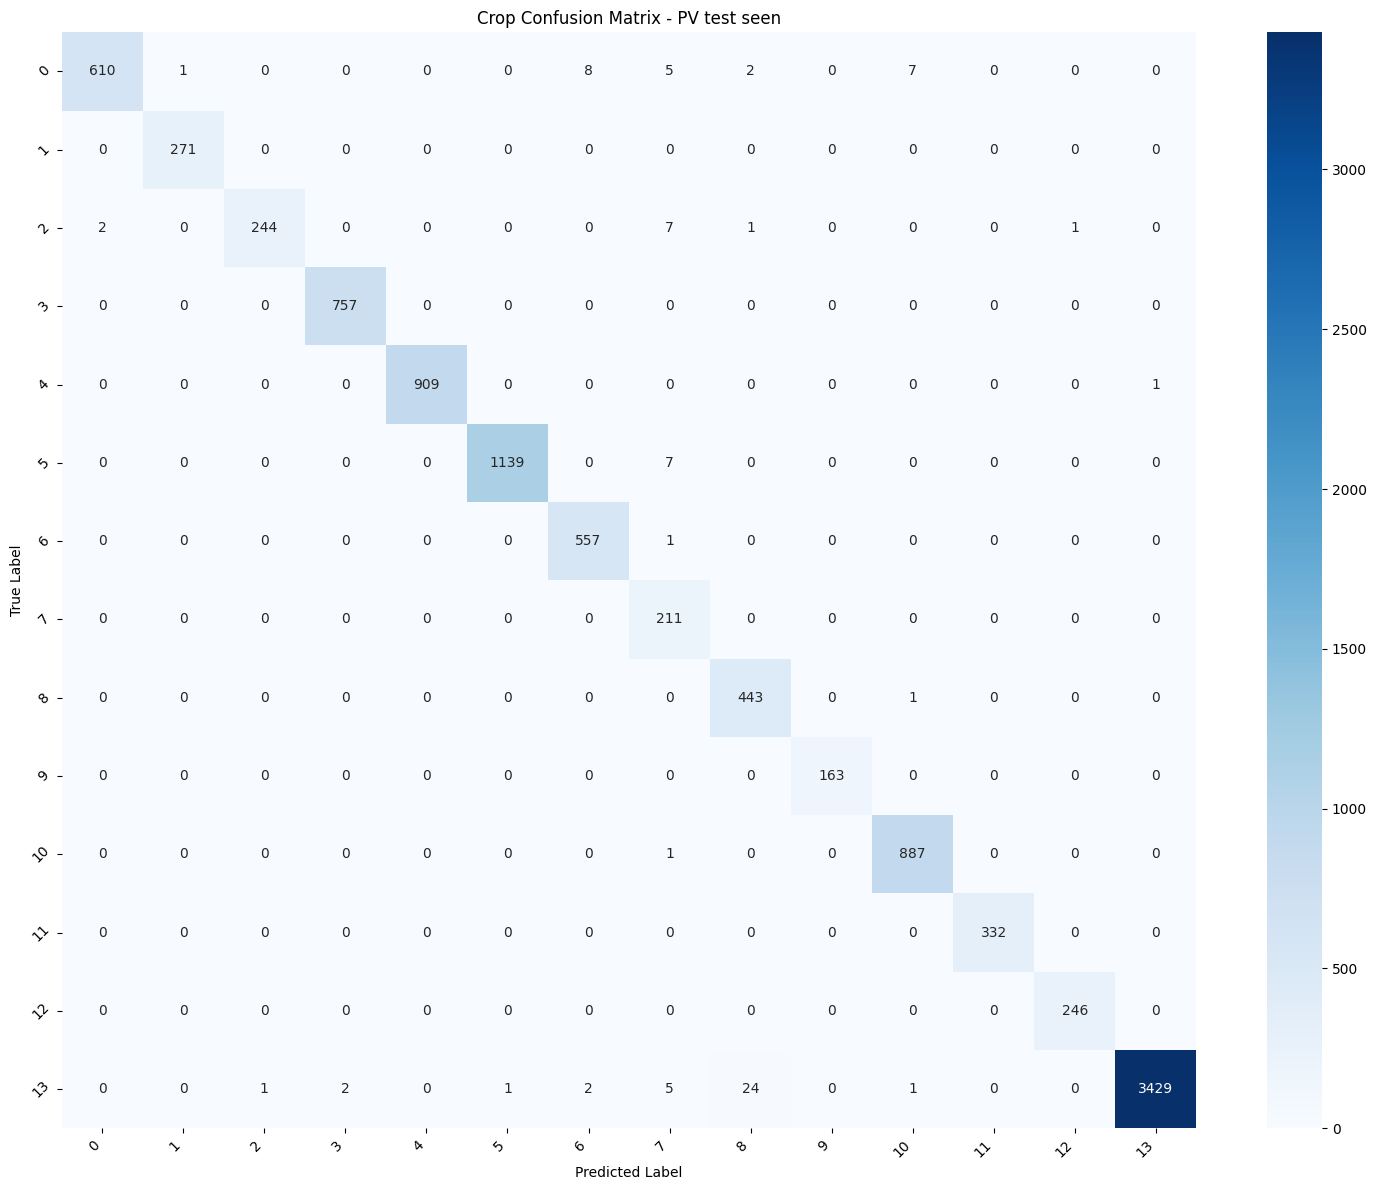


Prediction Distribution:
Class 0: 612 predictions (5.95%)
Class 1: 272 predictions (2.65%)
Class 2: 245 predictions (2.38%)
Class 3: 759 predictions (7.38%)
Class 4: 909 predictions (8.84%)
Class 5: 1140 predictions (11.09%)
Class 6: 567 predictions (5.52%)
Class 7: 237 predictions (2.31%)
Class 8: 470 predictions (4.57%)
Class 9: 163 predictions (1.59%)
Class 10: 896 predictions (8.72%)
Class 11: 332 predictions (3.23%)
Class 12: 247 predictions (2.40%)
Class 13: 3430 predictions (33.37%)

Plotting Disease Confusion Matrix...


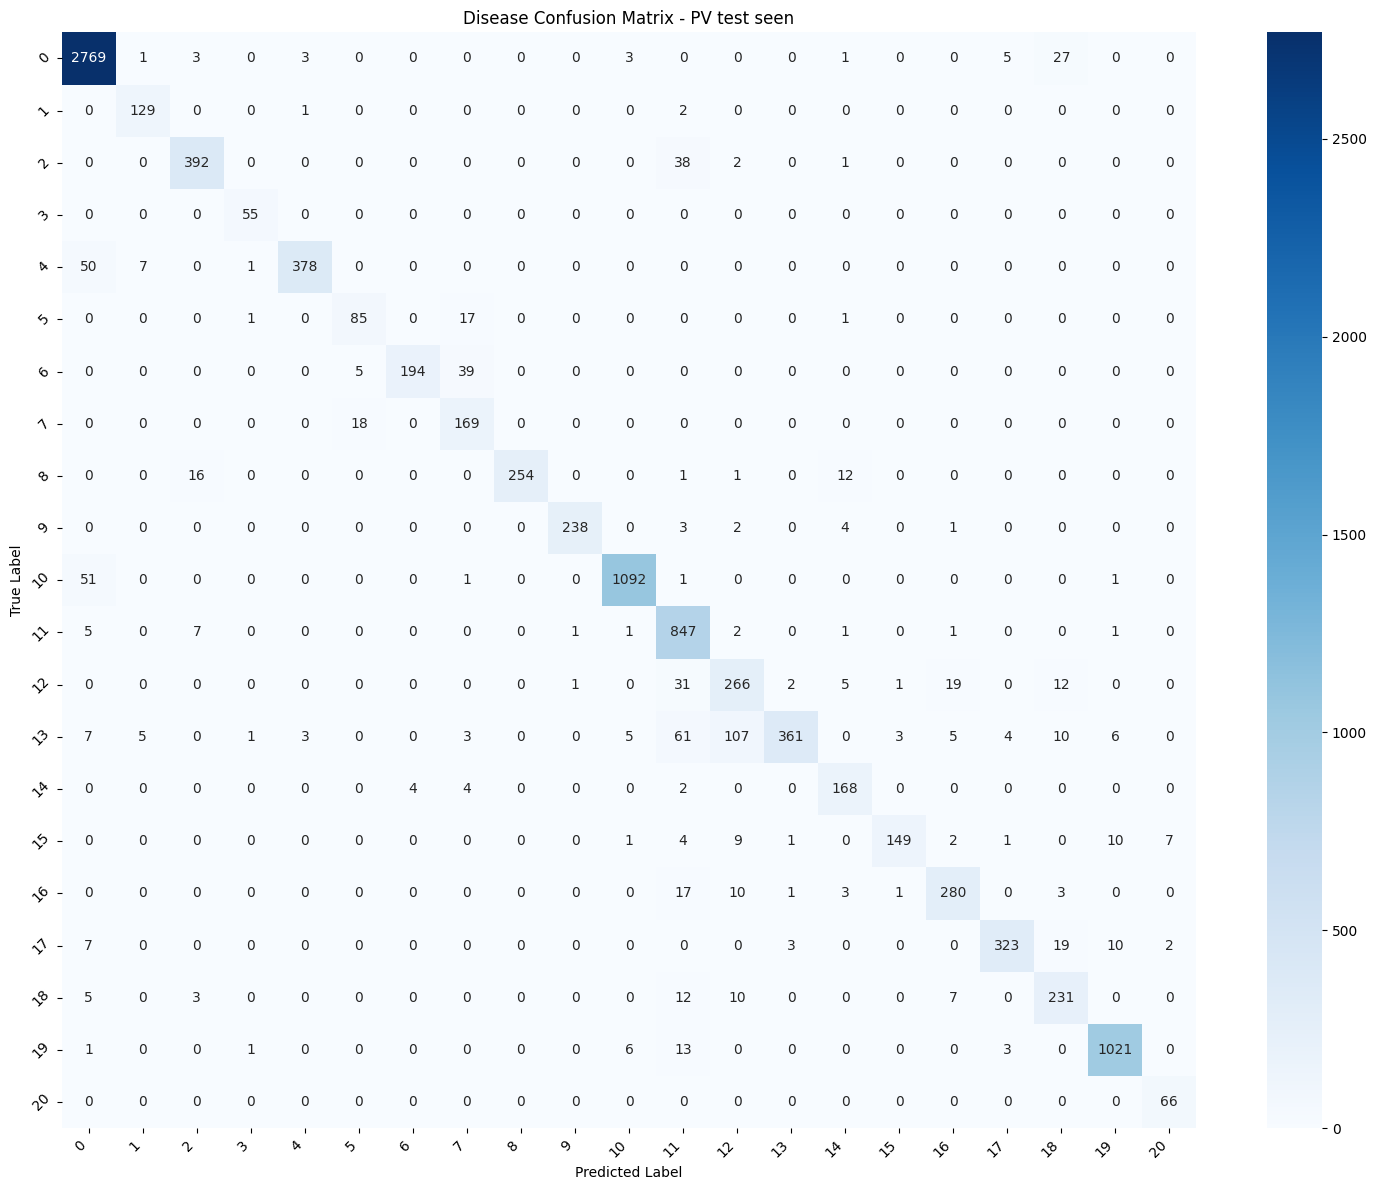


Prediction Distribution:
Class 0: 2895 predictions (28.16%)
Class 1: 142 predictions (1.38%)
Class 2: 421 predictions (4.10%)
Class 3: 59 predictions (0.57%)
Class 4: 385 predictions (3.75%)
Class 5: 108 predictions (1.05%)
Class 6: 198 predictions (1.93%)
Class 7: 233 predictions (2.27%)
Class 8: 254 predictions (2.47%)
Class 9: 240 predictions (2.33%)
Class 10: 1108 predictions (10.78%)
Class 11: 1032 predictions (10.04%)
Class 12: 409 predictions (3.98%)
Class 13: 368 predictions (3.58%)
Class 14: 196 predictions (1.91%)
Class 15: 154 predictions (1.50%)
Class 16: 315 predictions (3.06%)
Class 17: 336 predictions (3.27%)
Class 18: 302 predictions (2.94%)
Class 19: 1049 predictions (10.21%)
Class 20: 75 predictions (0.73%)

Processing PV test unseen...
Found 1 unique crop labels, 1 unique disease labels
Valid images found: 216
Evaluating PV test unseen...


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.09batch/s]


Results for PV test unseen:

Crop Classification Results
Top-1 Accuracy: 96.30%
Top-5 Accuracy: 100.00%
Average Accuracy: 96.30%

Disease Classification Results
Top-1 Accuracy: 71.30%
Top-5 Accuracy: 96.30%
Average Accuracy: 71.30%

Plotting Crop Confusion Matrix...


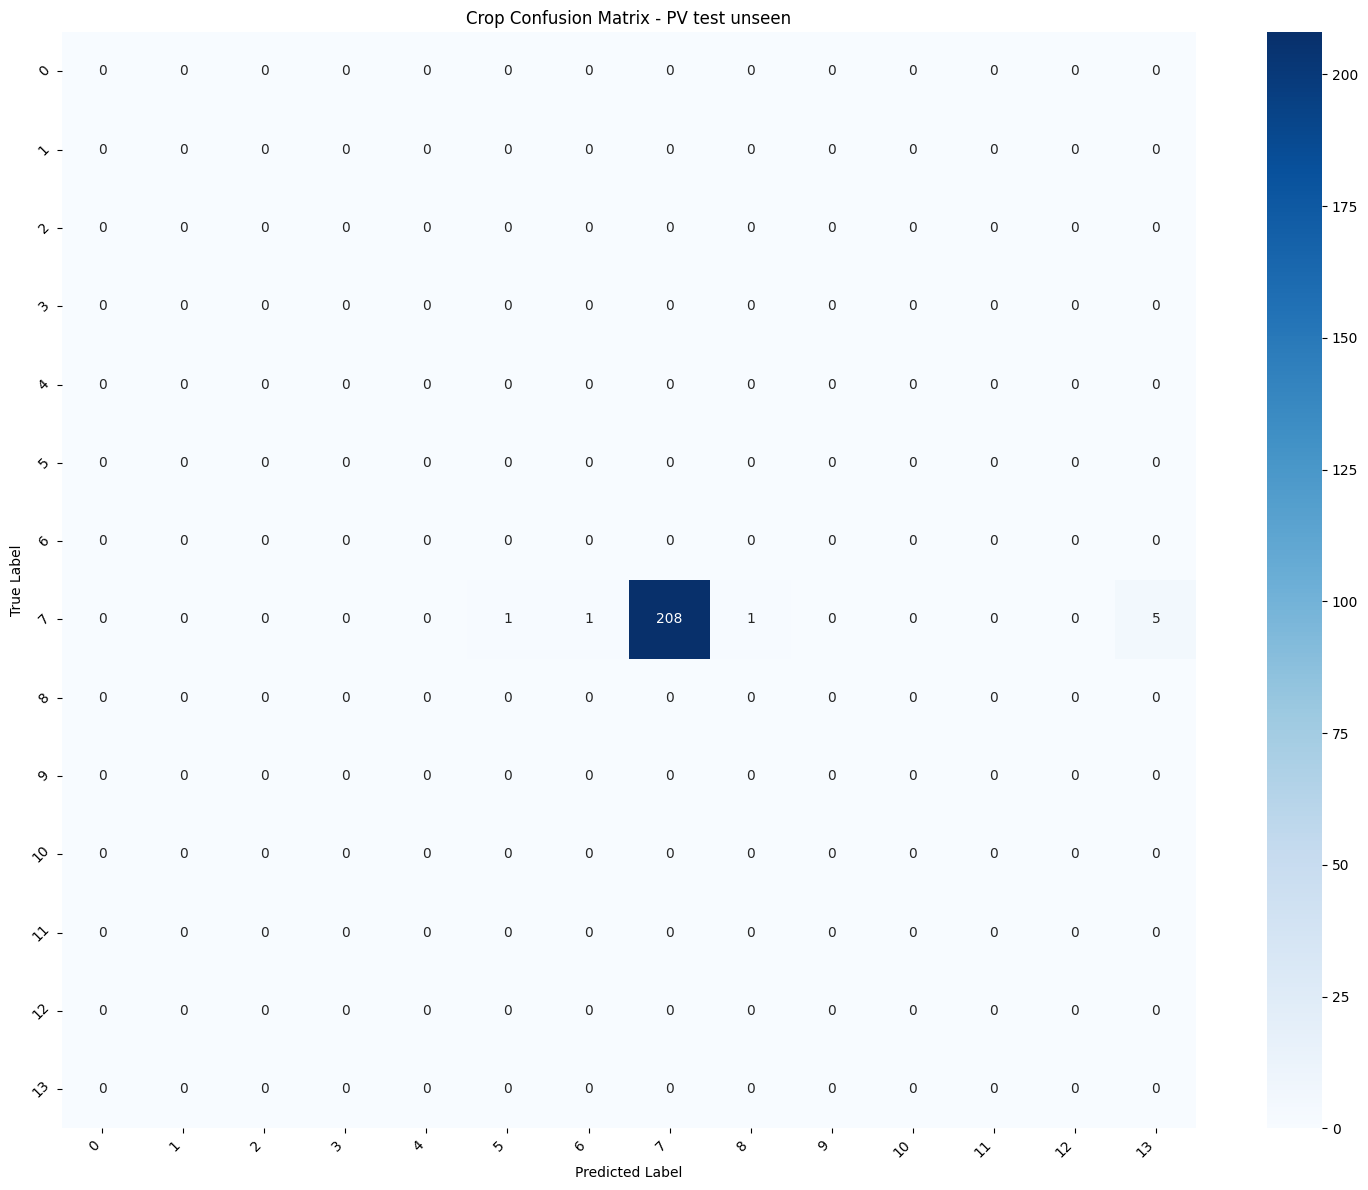


Prediction Distribution:
Class 5: 1 predictions (0.46%)
Class 6: 1 predictions (0.46%)
Class 7: 208 predictions (96.30%)
Class 8: 1 predictions (0.46%)
Class 13: 5 predictions (2.31%)

Plotting Disease Confusion Matrix...


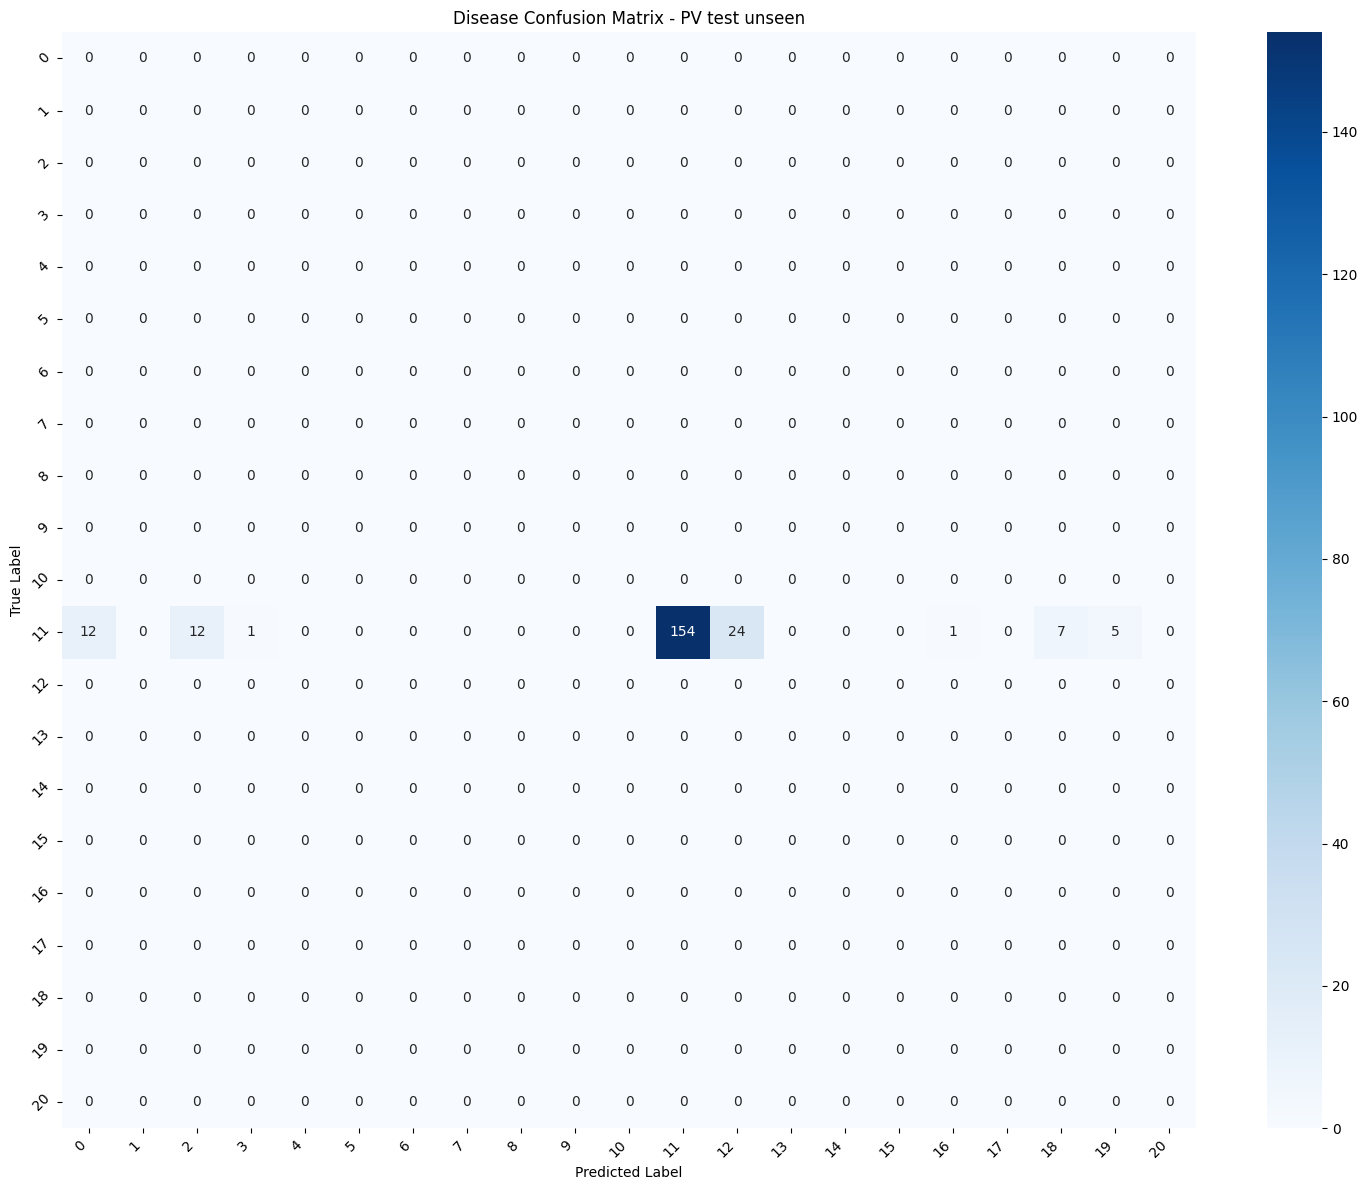


Prediction Distribution:
Class 0: 12 predictions (5.56%)
Class 2: 12 predictions (5.56%)
Class 3: 1 predictions (0.46%)
Class 11: 154 predictions (71.30%)
Class 12: 24 predictions (11.11%)
Class 16: 1 predictions (0.46%)
Class 18: 7 predictions (3.24%)
Class 19: 5 predictions (2.31%)

Processing PD test unseen...
Found 1 unique crop labels, 1 unique disease labels
Valid images found: 71
Evaluating PD test unseen...


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  1.71batch/s]


Results for PD test unseen:

Crop Classification Results
Top-1 Accuracy: 19.72%
Top-5 Accuracy: 69.01%
Average Accuracy: 19.72%

Disease Classification Results
Top-1 Accuracy: 32.39%
Top-5 Accuracy: 90.14%
Average Accuracy: 32.39%

Plotting Crop Confusion Matrix...


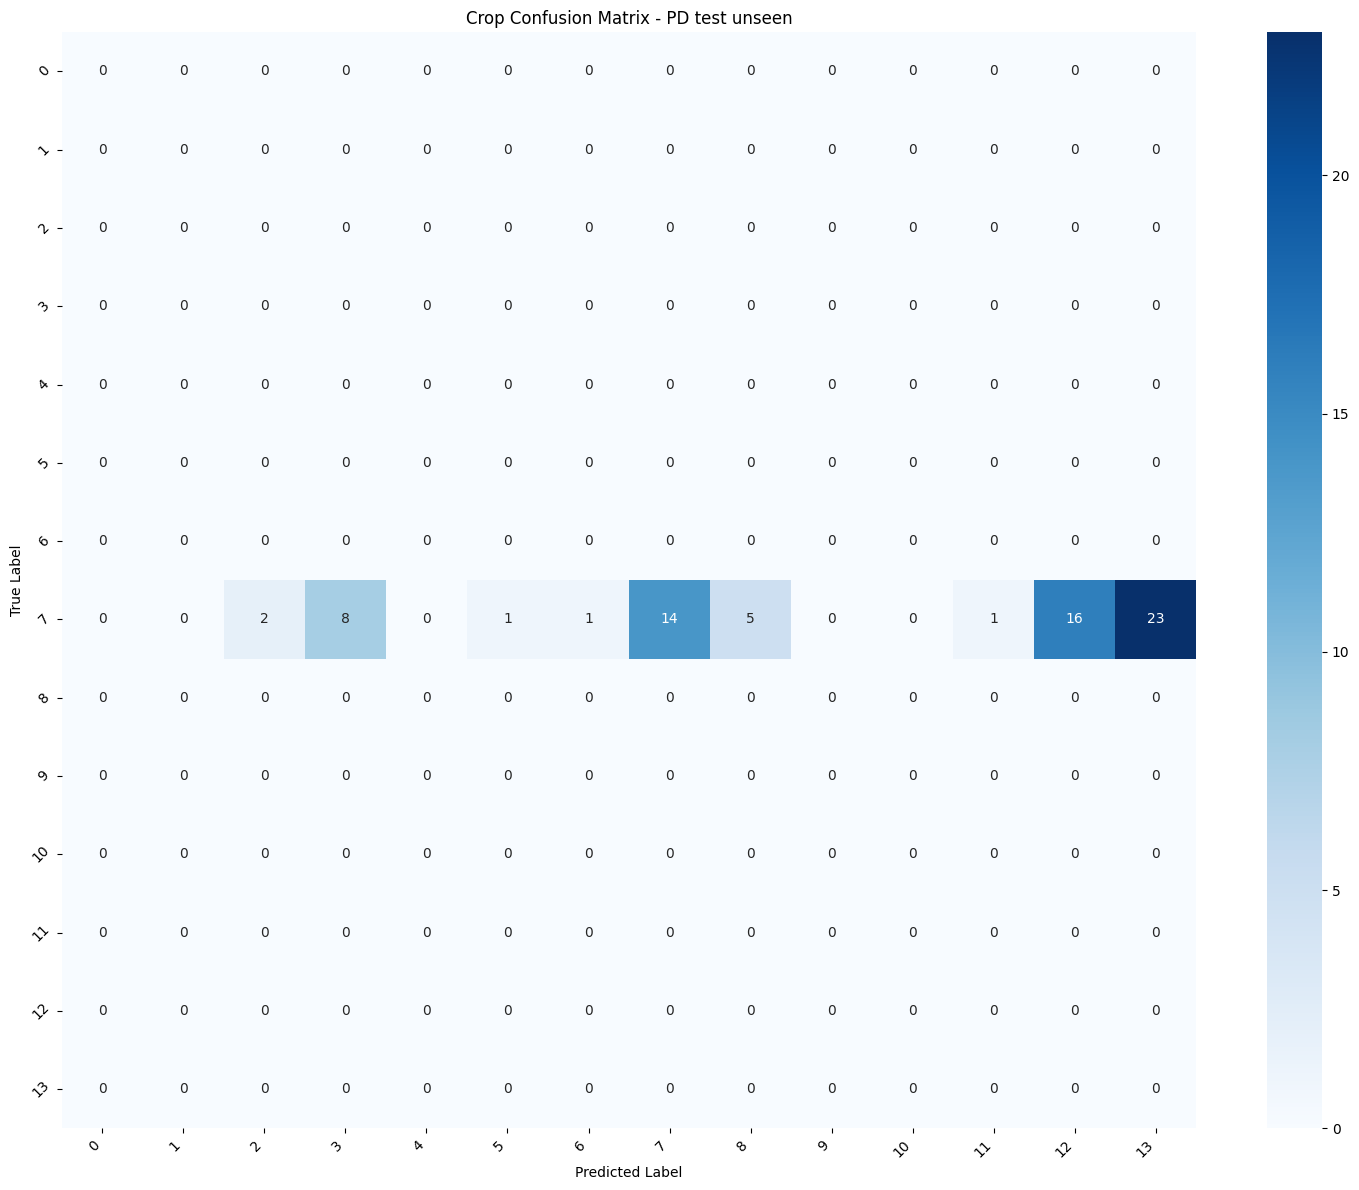


Prediction Distribution:
Class 2: 2 predictions (2.82%)
Class 3: 8 predictions (11.27%)
Class 5: 1 predictions (1.41%)
Class 6: 1 predictions (1.41%)
Class 7: 14 predictions (19.72%)
Class 8: 5 predictions (7.04%)
Class 11: 1 predictions (1.41%)
Class 12: 16 predictions (22.54%)
Class 13: 23 predictions (32.39%)

Plotting Disease Confusion Matrix...


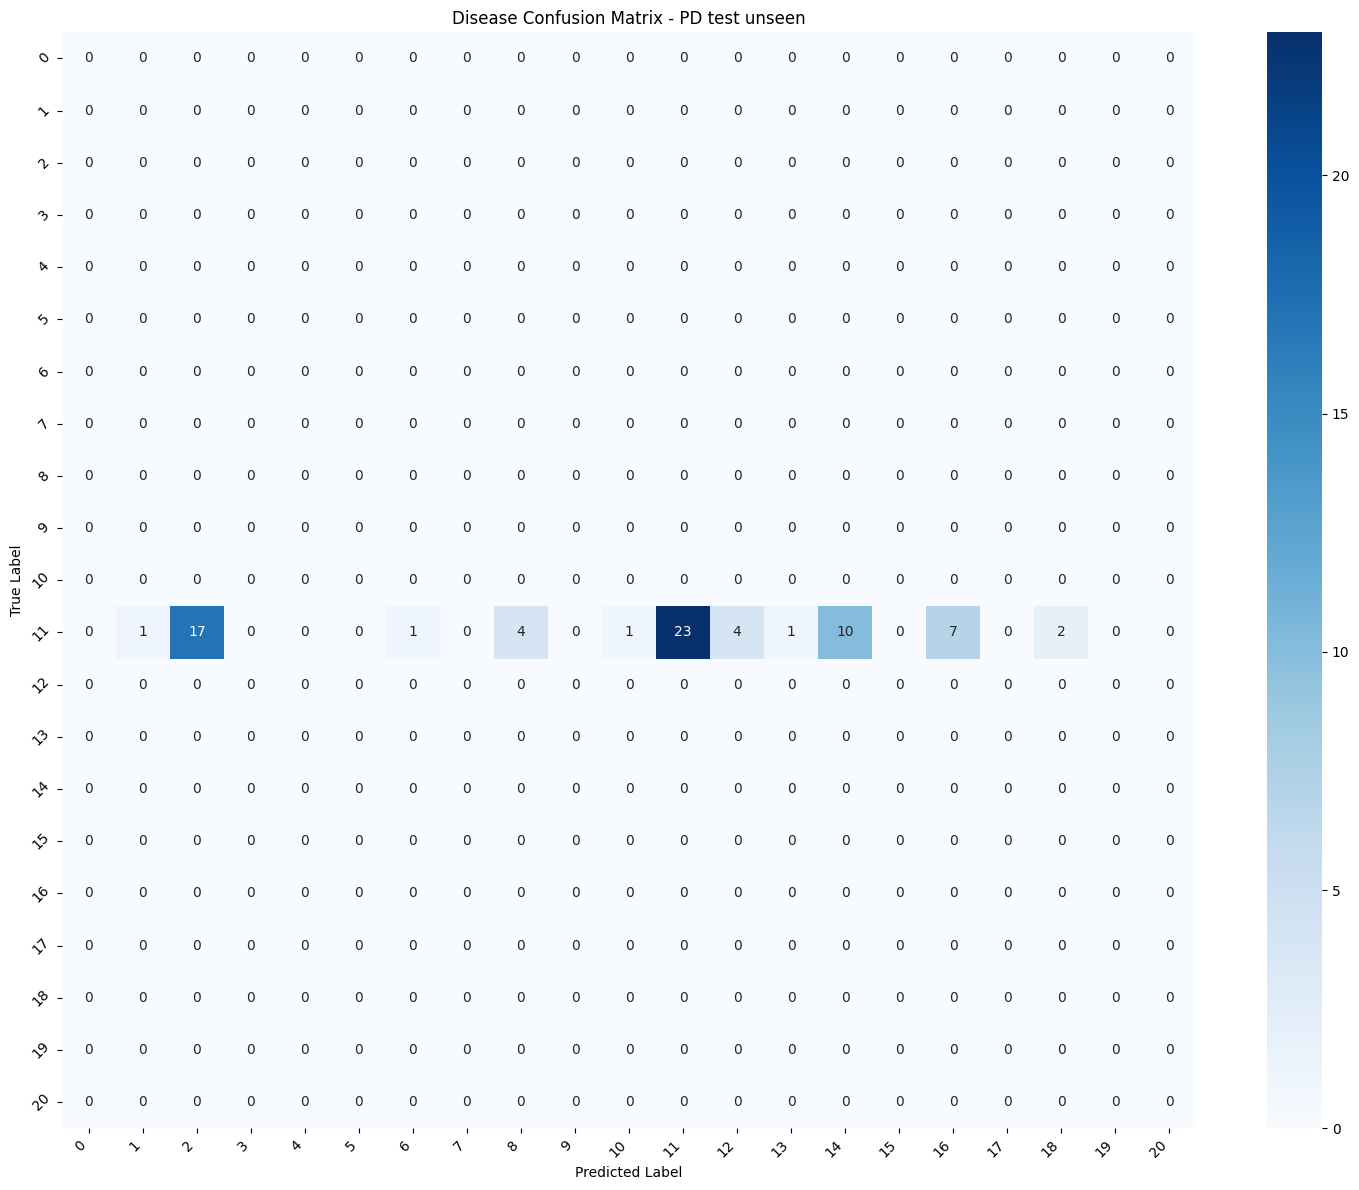


Prediction Distribution:
Class 1: 1 predictions (1.41%)
Class 2: 17 predictions (23.94%)
Class 6: 1 predictions (1.41%)
Class 8: 4 predictions (5.63%)
Class 10: 1 predictions (1.41%)
Class 11: 23 predictions (32.39%)
Class 12: 4 predictions (5.63%)
Class 13: 1 predictions (1.41%)
Class 14: 10 predictions (14.08%)
Class 16: 7 predictions (9.86%)
Class 18: 2 predictions (2.82%)

Harmonic Means for Crop:
----------------------------------------
PV Seen vs PV Unseen: 97.73%
PV Seen vs PD Unseen: 32.90%
PV Seen vs (PV Unseen + PD Unseen Average): 73.21%

Harmonic Means for Disease:
----------------------------------------
PV Seen vs PV Unseen: 80.37%
PV Seen vs PD Unseen: 47.93%
PV Seen vs (PV Unseen + PD Unseen Average): 66.34%

Results saved to evaluation_results.csv
Model: best_model_6_54_t_a
Saved metrics for test sets: PV test seen, PV test unseen, PD test unseen

Metrics included for each test set:
- Crop Top-1 Accuracy
- Crop Top-5 Accuracy
- Crop Average Accuracy
- Disease Top-1 Ac

In [2]:
def main():
    # Set up device (CPU/GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        # Get label mappings from seen dataset
        label_mapping = get_label_mapping('PV test seen.csv')
        print("Label mapping from seen dataset:", label_mapping)

        # Initialize model with correct parameters
        model = CompZSLNet(
            num_crops=14,
            num_diseases=21,
            num_compositions=37,
            pretrained=False,
            feature_dim=256
        )
        model = model.to(device)
        
        # Load model weights with security parameter
        state_dict = torch.load('best_model_6_54_t_a.pth', map_location=device, weights_only=True)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
        model.eval()
        print("Model loaded successfully")

        # Define test configurations
        test_configs = {
            'PV test seen': {
                'dir': 'PV test seen',
                'csv': 'PV test seen.csv',
                'domain': 'lab'
            },
            'PV test unseen': {
                'dir': 'PV test unseen',
                'csv': 'PV test unseen.csv',
                'domain': 'lab'
            },
            'PD test unseen': {
                'dir': 'PD test unseen',
                'csv': 'PD test unseen.csv',
                'domain': 'field'
            }
        }

        # Store results for all test sets
        all_results = {}

        # Process each test configuration
        for name, config in test_configs.items():
            try:
                print(f"\nProcessing {name}...")
                # Create dataset
                dataset = CustomDataset(
                    img_dir=config['dir'],
                    csv_path=config['csv'],
                    transform=transform,
                    label_mapping=label_mapping,
                    domain=config['domain']
                )

                if len(dataset) == 0:
                    print(f"No valid images found in {name}")
                    continue

                # Create dataloader
                dataloader = DataLoader(
                    dataset,
                    batch_size=32,
                    shuffle=False,
                    num_workers=0
                )

                # Evaluate model
                print(f"Evaluating {name}...")
                eval_results = evaluate_model(model, dataloader, device)
                all_results[name] = eval_results

                # Display results for current test set
                print(f"Results for {name}:")
                for task in ['crop', 'disease']:
                    print(f"\n{task.title()} Classification Results")
                    print("=" * 40)
                    print(f"Top-1 Accuracy: {eval_results['top1_accuracy'][task]:.2f}%")
                    print(f"Top-5 Accuracy: {eval_results['top5_accuracies'][task]:.2f}%")
                    print(f"Average Accuracy: {eval_results['avg_accuracy'][task]:.2f}%")

                # Generate and display confusion matrices
                for task, num_classes in [('crop', 14), ('disease', 21)]:
                    print(f"\nPlotting {task.title()} Confusion Matrix...")
                    plot_confusion_matrix(
                        eval_results['labels'][task],
                        eval_results['predictions'][task],
                        list(range(num_classes)),
                        f'{task.title()} Confusion Matrix - {name}'
                    )

            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
                continue

        # Calculate and display harmonic means
        if all(k in all_results for k in ['PV test seen', 'PV test unseen', 'PD test unseen']):
            for task in ['crop', 'disease']:
                # Get accuracies for each test set
                seen_acc = all_results['PV test seen']['top1_accuracy'][task]
                unseen_acc_pv = all_results['PV test unseen']['top1_accuracy'][task]
                unseen_acc_pd = all_results['PD test unseen']['top1_accuracy'][task]

                # Calculate three different harmonic means
                h_mean_pv = (2 * seen_acc * unseen_acc_pv) / (seen_acc + unseen_acc_pv)
                h_mean_pd = (2 * seen_acc * unseen_acc_pd) / (seen_acc + unseen_acc_pd)
                h_mean_pv_pd = (2 * seen_acc * ((unseen_acc_pv + unseen_acc_pd)/2)) / (
                        seen_acc + ((unseen_acc_pv + unseen_acc_pd)/2))

                # Display harmonic means
                print(f"\nHarmonic Means for {task.title()}:")
                print("-" * 40)
                print(f"PV Seen vs PV Unseen: {h_mean_pv:.2f}%")
                print(f"PV Seen vs PD Unseen: {h_mean_pd:.2f}%")
                print(f"PV Seen vs (PV Unseen + PD Unseen Average): {h_mean_pv_pd:.2f}%")

        # Save all results to CSV
        model_name = "best_model_6_54_t_a"
        save_results_to_csv(all_results, model_name)

    except Exception as e:
        print(f"An error occurred in main: {str(e)}")
        raise

if __name__ == "__main__":
    main()